# <a id='toc1_'></a>[LSTM MODEL FOR TIME SERIES ANALYSIS](#toc0_)
----

**Table of contents**<a id='toc0_'></a>    
- [LSTM MODEL FOR TIME SERIES ANALYSIS](#toc1_)    
  - [Import Libraries](#toc1_1_)    
  - [Get Data](#toc1_2_)    
  - [Sliding Window & Preprocessing](#toc1_3_)    
  - [Define LSTM Model](#toc1_4_)    
- [Model Initialization](#toc2_)    
  - [Define Model Training Parameters And Training](#toc2_1_)    
  - [Model Forecast Plot](#toc2_2_)    
  - [Learning Curves for Training and Validation Accuracy (200 Epochs) and all epochs](#toc2_3_)    
  - [Directional Predictive Accuracy](#toc2_4_)    
  - [Distribution of Residuals](#toc2_5_)    
  - [Summary of Metrics](#toc2_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL --
----

----
## <a id='toc1_1_'></a>[Import Libraries](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error

## Importing dependent file
import LSTMpy as lstmm


## Import nessesary packages
import statsmodels.api as sm
import statsmodels.stats.diagnostic
from tabulate import tabulate
from scipy import stats

## import tabulate for latex table
from tabulate import tabulate

# Set seed for reproducability
np.random.seed(42)
torch.manual_seed(42)

% matplotlib inline
% load_ext autoreload

UsageError: Line magic function `%` not found.


## <a id='toc1_2_'></a>[Get Data](#toc0_)

In [2]:
## Get Data form RiksBanken
column = "SEK/DKK"

data = pd.read_csv("20_year_data.csv", delimiter=";")

data['Date'] = pd.to_datetime(data['Date'], format = '%d/%m/%Y')
data = data.set_index('Date')

data = data.replace(to_replace=",", value=".", regex=True)

## choose only the "Value" column with iloc
data = data.iloc[:, 2:3]

data

,Value
Date,
2003-05-02,0.815
2003-05-05,0.8173
2003-05-06,0.8173
2003-05-07,0.8173
2003-05-08,0.8153
...,...
2023-04-25,0.6592
2023-04-26,0.6573
2023-04-27,0.654


In [3]:
print(data.shape)

(5028, 1)


## <a id='toc1_3_'></a>[Sliding Window & Preprocessing](#toc0_)

In [4]:
seq_length = 30
train_ratio = 0.8
val_ratio = 0.1581
batch_size = 32

trainX, trainY, valX, valY, testX, testY, sc, train_size, val_size, test_size, y, data_normalized = lstmm.preprocessing(data, seq_length, train_ratio, val_ratio)

## <a id='toc1_4_'></a>[Define LSTM Model](#toc0_)

In [5]:
# LSTM model definition

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        ## Define the parameters
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.batch_size = batch_size

        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True
        )

        self.fc = nn.Linear(hidden_size, num_classes)

    # Define the forward pass
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)
        return out

# <a id='toc2_'></a>[Model Initialization](#toc0_)

## <a id='toc2_1_'></a>[Define Model Training Parameters And Training](#toc0_)

In [6]:
# Set seed for reproducability
np.random.seed(42)
torch.manual_seed(42)

# Model training
num_epochs = 7000
learning_rate = 0.001

# Set size of LSTM
input_size = 1
hidden_size = 50
num_layers = 1
num_classes = 1

# Initialize LSTM model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

# Define loss function and optimizer (MSE and Adam)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
train_losses = []
val_losses = []


# Train the model (Back Propagation)
for epoch in (range(num_epochs)):
    # Training
    lstm.train()
    outputs = lstm(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    # Validation
    lstm.eval()
    val_outputs = lstm(valX)
    val_loss = criterion(val_outputs, valY)

    # Save losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if epoch % 100 == 0:
        print("Epoch: %d, Training Loss: %1.5f, Validation Loss: %1.5f" % (epoch, loss.item(), val_loss.item()))

       


Epoch: 0, Training Loss: 0.51443, Validation Loss: 0.15676
Epoch: 100, Training Loss: 0.00928, Validation Loss: 0.03336
Epoch: 200, Training Loss: 0.00098, Validation Loss: 0.00180
Epoch: 300, Training Loss: 0.00065, Validation Loss: 0.00049
Epoch: 400, Training Loss: 0.00062, Validation Loss: 0.00045
Epoch: 500, Training Loss: 0.00059, Validation Loss: 0.00043
Epoch: 600, Training Loss: 0.00056, Validation Loss: 0.00040
Epoch: 700, Training Loss: 0.00053, Validation Loss: 0.00038
Epoch: 800, Training Loss: 0.00050, Validation Loss: 0.00036
Epoch: 900, Training Loss: 0.00047, Validation Loss: 0.00034
Epoch: 1000, Training Loss: 0.00044, Validation Loss: 0.00031
Epoch: 1100, Training Loss: 0.00041, Validation Loss: 0.00029
Epoch: 1200, Training Loss: 0.00040, Validation Loss: 0.00028
Epoch: 1300, Training Loss: 0.00039, Validation Loss: 0.00027
Epoch: 1400, Training Loss: 0.00037, Validation Loss: 0.00026
Epoch: 1500, Training Loss: 0.00036, Validation Loss: 0.00025
Epoch: 1600, Trainin

## <a id='toc2_2_'></a>[Model Forecast Plot](#toc0_)

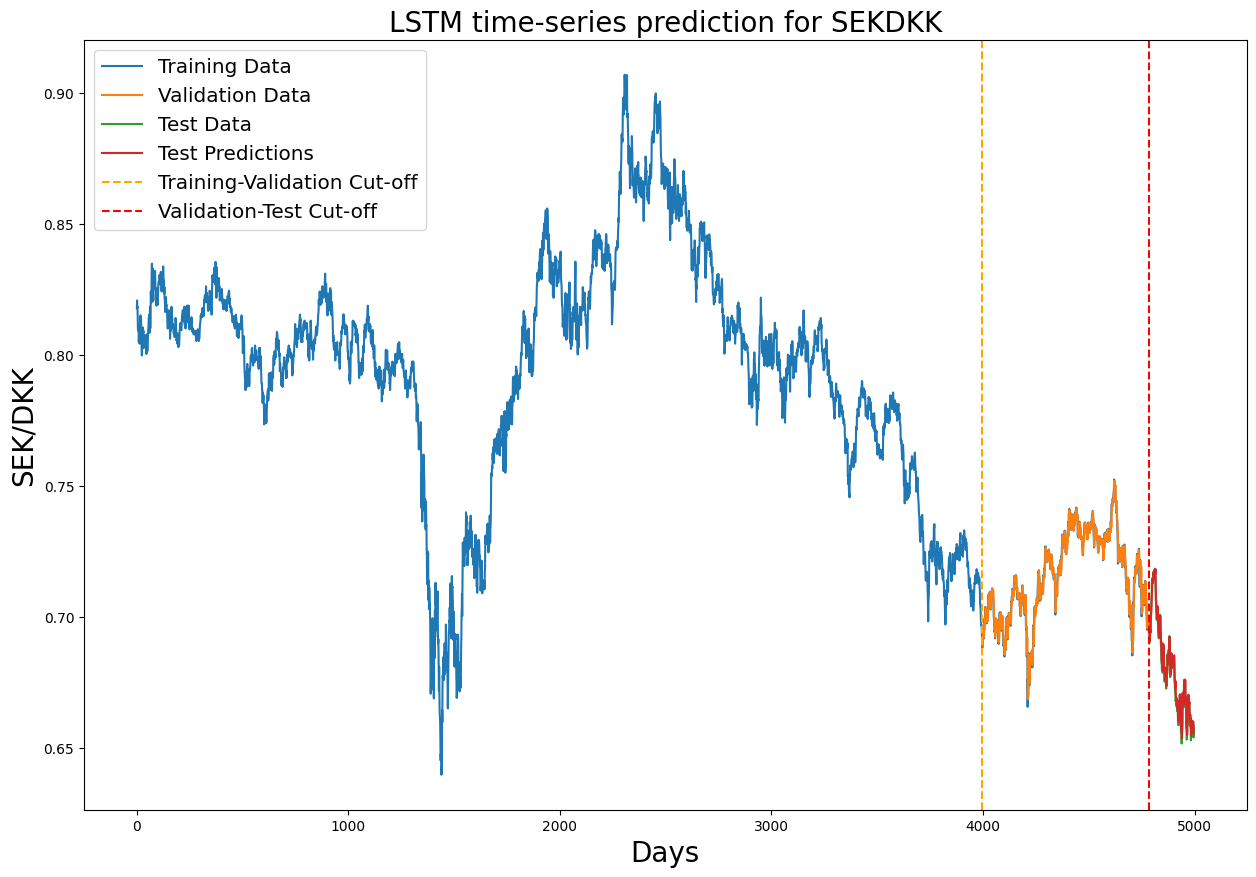

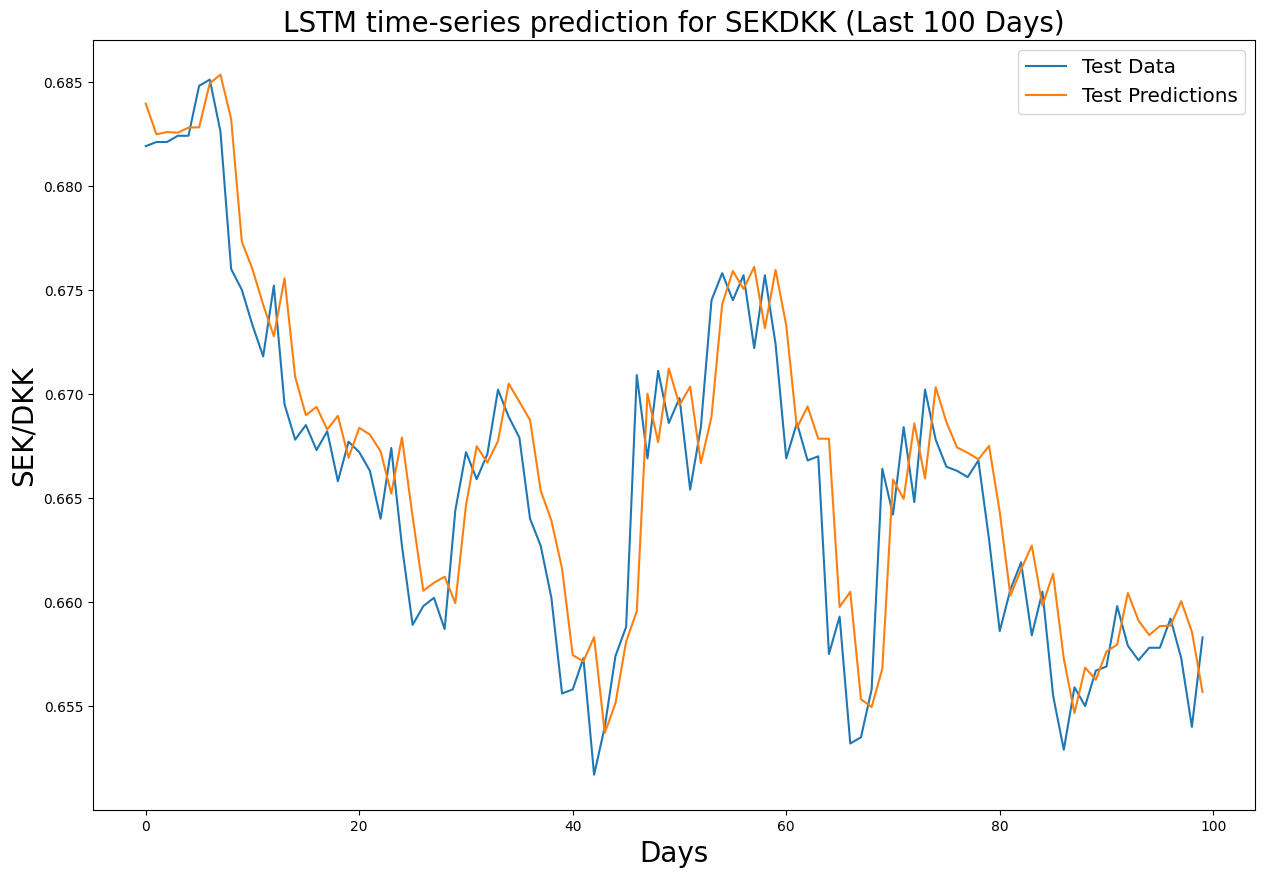

In [7]:
# Model evaluation

import LSTMpy as lstmm
import importlib
importlib.reload(lstmm)

# Iverse transform from MinMaxScaler to normal values
lstm.eval()
train_predict = lstm(torch.cat((trainX, valX)))
test_predict = lstm(testX)
train_predict = sc.inverse_transform(train_predict.data.numpy())
trainY_plot = sc.inverse_transform(torch.cat((trainY, valY)).data.numpy())
test_predict = sc.inverse_transform(test_predict.data.numpy())
testY_plot = sc.inverse_transform(testY.data.numpy())

lstmm.model_eval(trainY_plot, train_predict, testY_plot, test_predict, train_size, val_size, test_size)


In [8]:
# Calculate the error metrics
lstmm.metrics(testY_plot, test_predict)

Test MSE: 9.821708e-06
Test R^2: 0.967972126583214
Test MAE: 0.002451524
Test Median AE: 0.0020160675
Test MAPE: 0.003619404
\begin{tabular}{lr}
\hline
 Metric   &       Value \\
\hline
 R\^{}2      & 0.967972    \\
 MSE      & 9.82171e-06 \\
 MAE      & 0.00245152  \\
 MAPE     & 0.0036194   \\
 RMSE     & 0.00313396  \\
\hline
\end{tabular}


## <a id='toc2_3_'></a>[Learning Curves for Training and Validation Accuracy (200 Epochs) and all epochs](#toc0_)

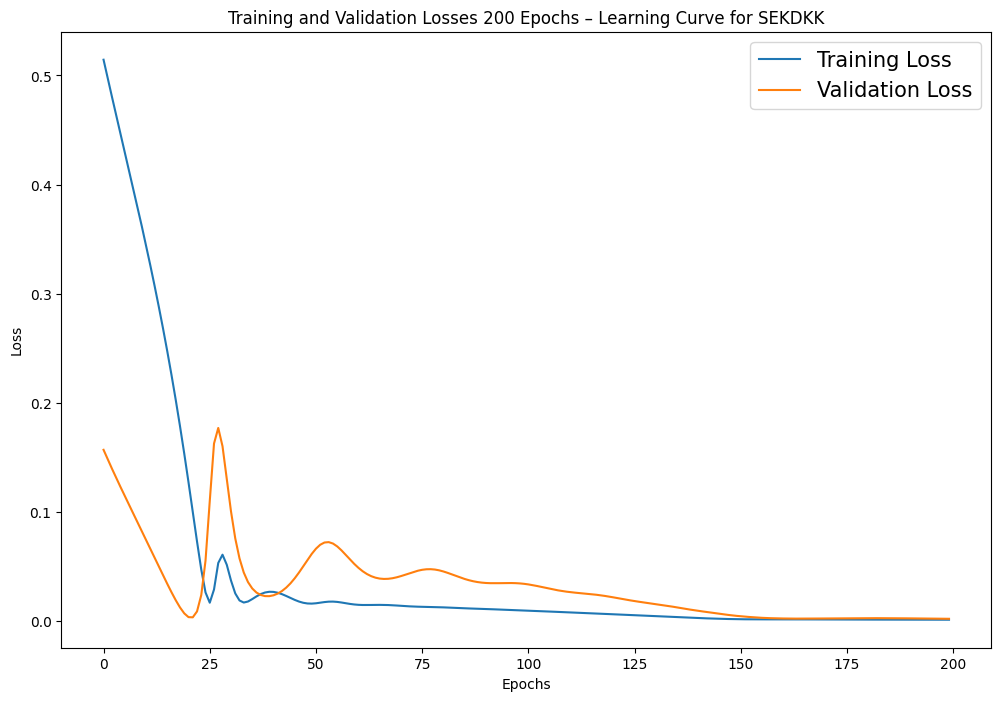

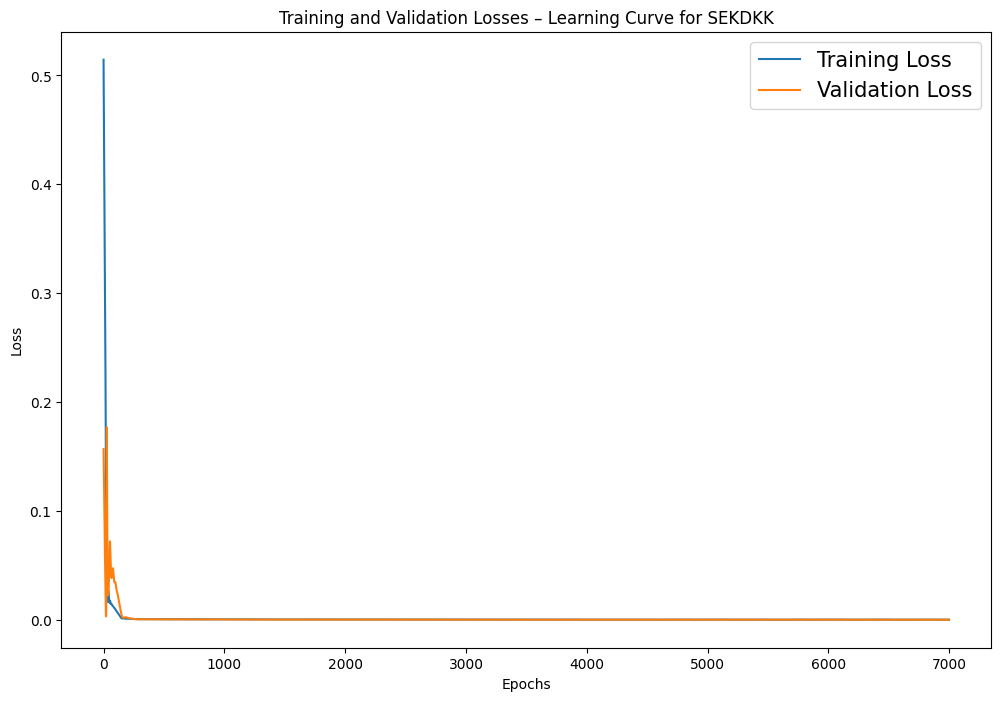

In [9]:
## Plots learning curves for all and 200 epochs
lstmm.plot_curve200(train_losses, val_losses)
lstmm.plot_curve_all(train_losses, val_losses)

## <a id='toc2_4_'></a>[Directional Predictive Accuracy](#toc0_)

In [21]:
# Directional Prediction Accuracy
import importlib
importlib.reload(lstmm)

lstmm.DPA(testY_plot, test_predict)

\begin{tabular}{lr}
\hline
                                  &   LSTM SEKDKK \\
\hline
 Counter                          &     -5        \\
 Total number of predictions      &    209        \\
 Number of correct directions     &    102        \\
 Number of false directions       &    107        \\
 Percentage of correct directions &      0.488038 \\
 Percentage of false directions   &      0.511962 \\
\hline
\end{tabular}


## <a id='toc2_5_'></a>[Distribution of Residuals](#toc0_)

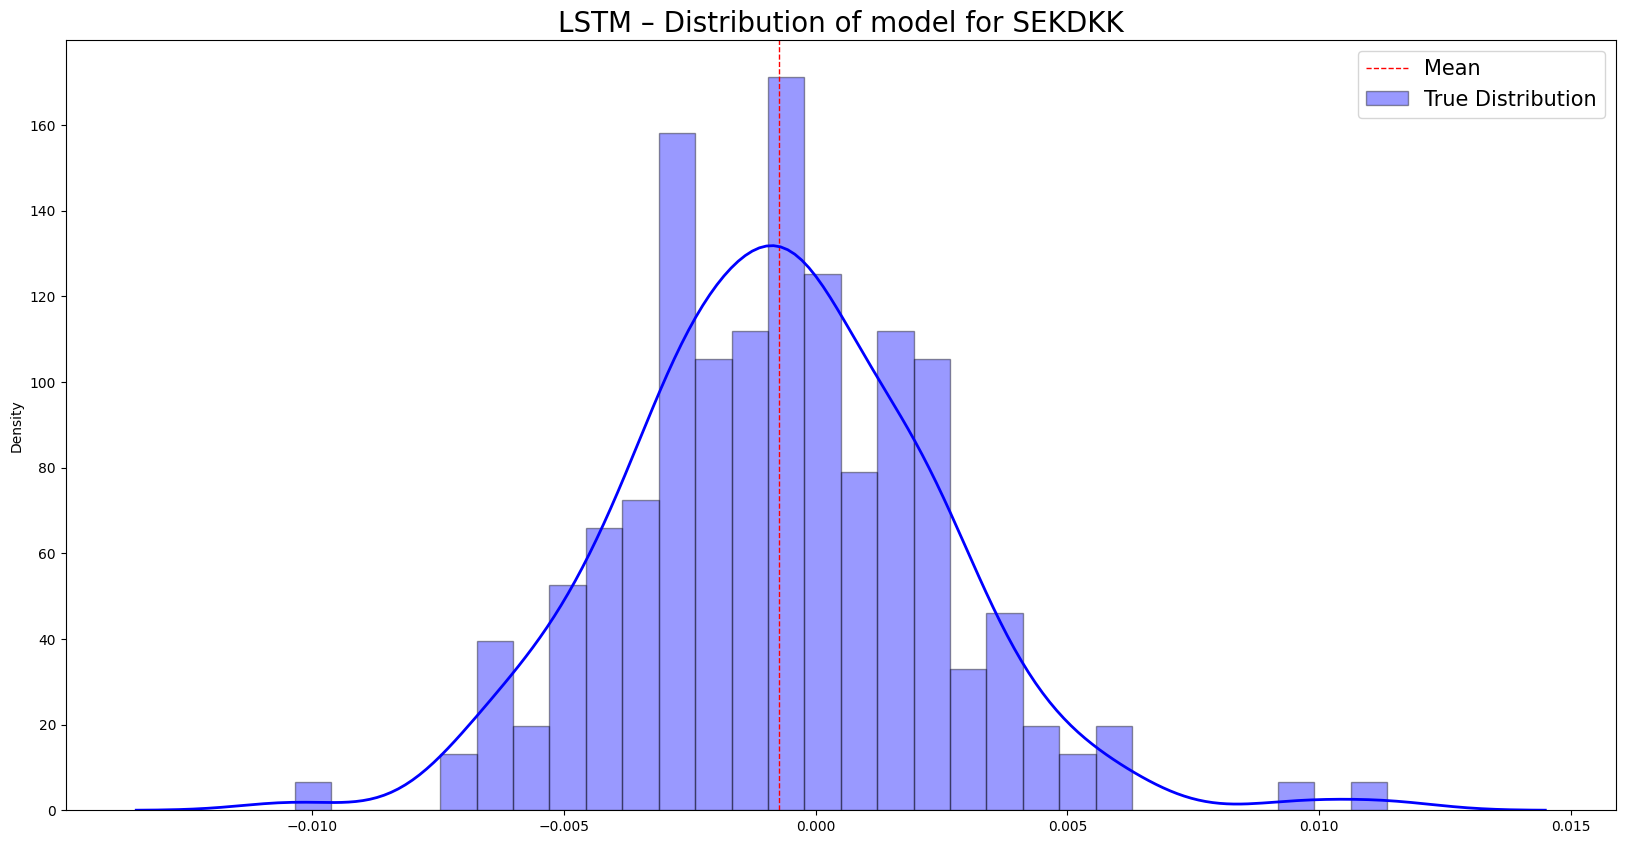

In [22]:
## Jarque-Bera test for normality of the residuals
## define residuals for the whole model
lstmm.dist(testY_plot, test_predict)

## <a id='toc2_6_'></a>[Summary of Metrics](#toc0_)

In [12]:
## Plot summary of the model along with white noise test, 
# ljung box test, 
# heteroscedasticity and normality test in a latex table using tabulate

residuals = testY_plot - test_predict
lstmm.summary_table(testY_plot, test_predict, residuals)

\begin{tabular}{lr}
\hline
 Summary LSTM – SEKDKK   &        Value \\
\hline
 Mean                    & -0.000733513 \\
 Standard Error          &  0.00304691  \\
 Skewness                &  0.309627    \\
 Kurtosis                &  1.1227      \\
 Jarque-Bera test        & 14.3844      \\
 p-value                 &  0.000752427 \\
 Ljung-Box test          &  7.90256     \\
 p-value                 &  0.161688    \\
 Heteroscedasticity      & 15.5983      \\
 p-value                 &  0.111723    \\
 Normality               & 10.1156      \\
 p-value                 &  0.00635961  \\
\hline
\end{tabular}
